___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [133]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

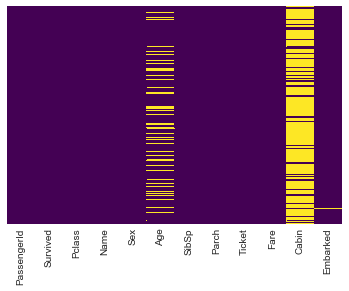

In [134]:
sns.heatmap(train.isnull(), yticklabels = False, cbar=False, cmap='viridis')
## THUS you can do a heatmap on any kind of dataframe, including a boolean mask like this

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

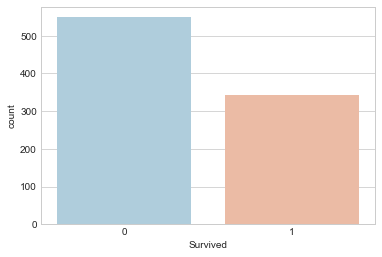

In [135]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data = train, palette = 'RdBu_r')

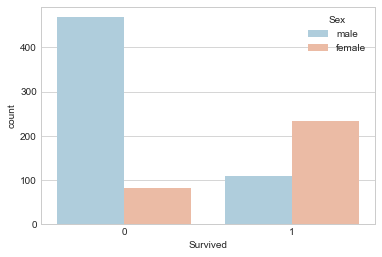

In [136]:
sns.countplot(x='Survived', data = train, hue='Sex', palette = 'RdBu_r')

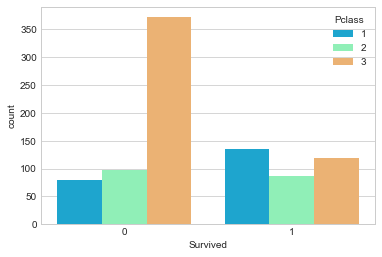

In [137]:
sns.countplot(x='Survived', data = train, hue='Pclass', palette = 'rainbow')

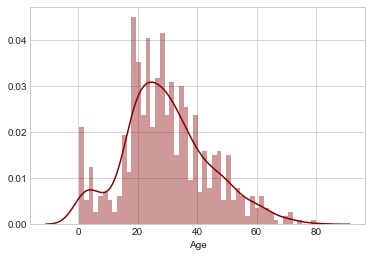

In [138]:
sns.distplot(train['Age'].dropna(),color='darkred',bins=50)

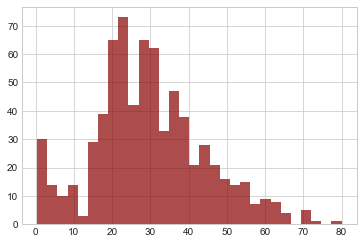

In [139]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

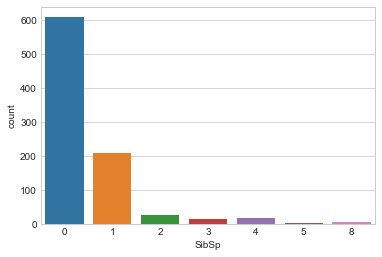

In [140]:
sns.countplot(x='SibSp',data=train)

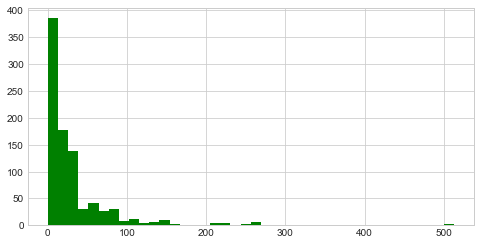

In [141]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks for plots
___
 Let's take a quick moment to show an example of cufflinks!

In [142]:
import cufflinks as cf
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [143]:
train['Fare'].iplot(kind='hist',bins=30)

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


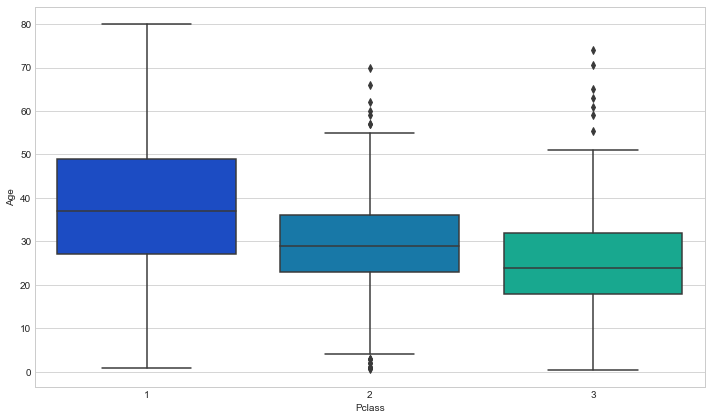

In [144]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [145]:
import math
math.floor(train[train['Pclass']==2]['Age'].mean())

29

In [146]:
def impute_age(columnRange):
    age = columnRange[0]
    Pclass = columnRange[1]
    
    if pd.isnull(age):
        return math.floor(train[train['Pclass']==Pclass]['Age'].mean())
    else:
        return age

In [147]:
# def impute_age(cols):
#     Age = cols[0]
#     Pclass = cols[1]
    
#     if pd.isnull(Age):

#         if Pclass == 1:
#             return 37

#         elif Pclass == 2:
#             return 29

#         else:
#             return 24

#     else:
#         return Age

Now apply that function!

In [148]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

In [149]:
train.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
342,343,0,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
671,672,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,38.0,0,0,113510,35.0000,C128,S
820,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
852,853,0,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C
381,382,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C
627,628,1,1,"Longley, Miss. Gretchen Fiske",female,21.0,0,0,13502,77.9583,D9,S
114,115,0,3,"Attalah, Miss. Malake",female,17.0,0,0,2627,14.4583,NaN,C
466,467,0,2,"Campbell, Mr. William",male,29.0,0,0,239853,0.0000,NaN,S


Now let's check that heat map again!

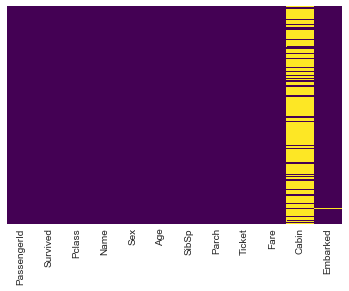

In [150]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [151]:
train.drop('Cabin',axis=1,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [152]:
train.dropna(inplace=True)

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [153]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [154]:
sex = pd.get_dummies(train['Sex'],drop_first=True) #Preven multi collineary when one column is perfect prediction of the other
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [155]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [156]:
train = pd.concat([train,sex,embark],axis=1)

In [157]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [158]:
train.drop(['PassengerId','Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
X = train.iloc[:,1:]
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Training and Predicting

In [161]:
from sklearn.linear_model import LogisticRegression

In [162]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [163]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [164]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.91      0.85       163
          1       0.82      0.65      0.73       104

avg / total       0.81      0.81      0.80       267

[[148  15]
 [ 36  68]]


In [165]:
testDF = pd.read_csv('titanic_test.csv')

In [166]:
testDF.drop('Cabin',axis=1,inplace=True)

In [167]:
testDF.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [168]:
testDF['Age'] = testDF[['Age','Pclass']].apply(impute_age,axis=1)

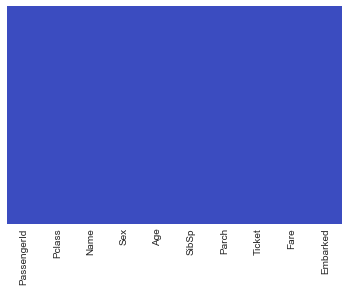

In [169]:
testDF.dropna(inplace=True)
sns.heatmap(testDF.isnull(),yticklabels=False, cbar=False, cmap='coolwarm')

In [170]:
sex = pd.get_dummies(testDF['Sex'],drop_first=True)
embark = pd.get_dummies(testDF['Embarked'],drop_first=True)
testDF = pd.concat([testDF,sex,embark],axis=1)
idColumn = testDF['PassengerId']
testDF.drop(['PassengerId','Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [126]:
newPredictions = logmodel.predict(testDF)


In [186]:
submission = pd.DataFrame({
 'Survived': newPredictions,
 },index=idColumn)

In [187]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!